# Imports

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
## Download images from Goggle

!pip install googleimagedownloader
from googleimagedownloader.googleimagedownloader import GoogleImageDownloader

# Testing an existing classifier

In [3]:
IMAGE_SIZE = (224, 224)

In [4]:
classifier_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4" 

In [5]:
classifier = Sequential([
    #image_size?
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SIZE+(3,))
])

98304/86910 [=================================] - 0s 1us/step


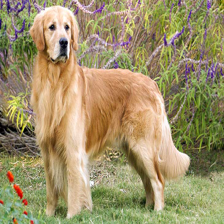

In [6]:
test_image = get_file('img.jpg','https://disenlis.com/wp-content/uploads/2019/01/Golden-Retriever-Standing1.jpg')
test_image = Image.open(test_image).resize(IMAGE_SIZE)
test_image

In [7]:
test_image = np.array(test_image)/255.0
test_image.shape

(224, 224, 3)

In [8]:
#newaxis
result = classifier.predict(test_image[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
#argmax
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

208

In [10]:
labels_path = get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


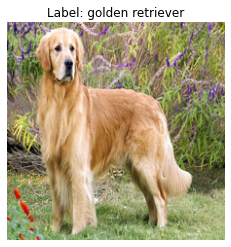

In [11]:
predicted_class_name = imagenet_labels[predicted_class]

plt.axis('off')
plt.title("Label: " + predicted_class_name, color = 'black')
plt.imshow(test_image)
plt.show()

# Transfer Learning

## Build the dataset

In [12]:
class_names = ['artoria_pendragon','nero_claudius']
path = 'dataset/'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_ca_dir = os.path.join(train_dir, 'artoria_pendragon')  
train_im_dir = os.path.join(train_dir, 'nero_claudius')  
validation_ca_dir = os.path.join(validation_dir, 'artoria_pendragon') 
validation_im_dir = os.path.join(validation_dir, 'nero_claudius')  

if os.path.exists(path):
  shutil.rmtree(path)

os.makedirs(train_ca_dir)
os.makedirs(train_im_dir)
os.makedirs(validation_ca_dir)    
os.makedirs(validation_im_dir)

In [13]:
#what is it?
def manage_images(src, dest_train, dest_val, image_resize=IMAGE_SIZE, val_split=0.1, prefix=''):
  total = len(os.listdir(src))
 #val split
  val = np.int(total*val_split)
  count = 0
  files = os.listdir(src)

  for file_name in files:
    try:
      dest = dest_train if count >= val else dest_val
      dest_file = os.path.join(dest, prefix + file_name) 

      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #resize
      img = img.resize(image_resize, Image.ANTIALIAS)
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return


In [14]:
img_dir = os.path.realpath('Images/')

In [15]:
queries = ['artoria pendragon','fate', 'armor', 'typemoon','cosplay']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='artoria pendragon '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_ca_dir, validation_ca_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=artoria pendragon artoria pendragon&source=lnms&tbm=isch
Total Time : 0:00:00.005348


FileNotFoundError: ignored

In [ ]:
queries = ['nero claudius','fate','armor','typemoon','cosplay']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='nero claudius '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_im_dir, validation_im_dir,prefix=str(pos)+'-')
  pos+=1

In [ ]:
total_train = len(os.listdir(train_ca_dir))+ len(os.listdir(train_im_dir))
total_val = len(os.listdir(validation_ca_dir))+ len(os.listdir(validation_im_dir))

print('total training artoria pendragon images:', len(os.listdir(train_ca_dir)))
print('total training nero claudius images:', len(os.listdir(train_im_dir)))

print('total validation artoria pendragon images:', len(os.listdir(validation_ca_dir)))
print('total validation nero claudius images:', len(os.listdir(validation_im_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

## Using the dataset

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='binary')

In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='binary')

## Testing the classifier

In [ ]:
image_batch, labels_batch = next(train_data_gen)

In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

In [ ]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

In [ ]:
plot_images(image_batch, labels_batch, predicted_class_names)

## Downloading headless model

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SIZE+(3,))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

In [ ]:
feature_extractor_layer.trainable = False

## Adding a classification head

In [ ]:
model = Sequential([
  feature_extractor_layer,
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.summary()

In [ ]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Train the model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

## Check results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()

plot_images(image_batch, labels_batch, predicted_class_names)

##Application base model

In [ ]:
base_model = ResNet50V2(input_shape=IMAGE_SIZE+(3,),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

In [ ]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')    
])
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 160
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=5,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_data_gen)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 7.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)